
>>> Procesando AMZ - TOP NODES

>>> Procesando AMZ - BOTTOM NODES

>>> Procesando AM - TOP NODES


/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_48123/1795764452.py:106: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_48123/1795764452.py:106: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)



>>> Procesando AM - BOTTOM NODES

>>> Procesando UM - TOP NODES

>>> Procesando UM - BOTTOM NODES


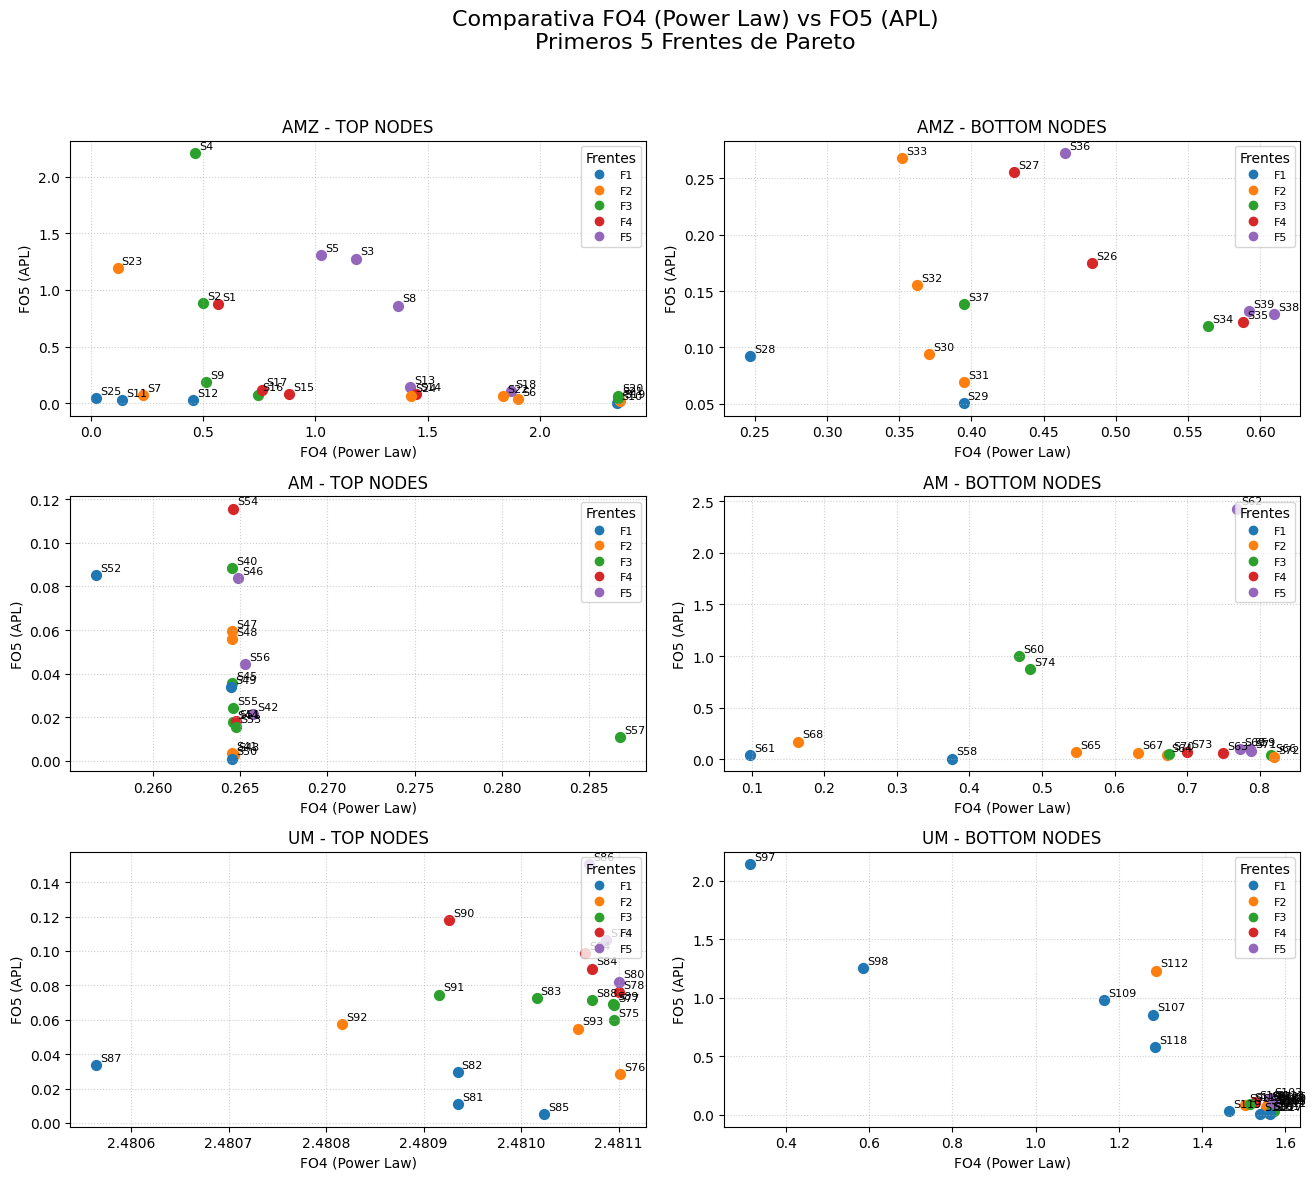

In [3]:
import os
import pickle
import itertools
import igraph as ig
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt

# --------------------------------------------------------
# CONFIGURACIÓN GENERAL
# --------------------------------------------------------
DATASETS = ["amz", "am", "um"]
NODETYPES = [0, 1]  # 0 = top, 1 = bottom
METRIC_PAIR = (3, 4)  # FO4 vs FO5
FO_NAMES = ['FO1 (Nodos)', 'FO2 (Densidad)', 'FO3 (CC)',
            'FO4 (Power Law)', 'FO5 (APL)', 'FO6 (Grado Promedio)']


# --------------------------------------------------------
# FUNCIONES AUXILIARES
# --------------------------------------------------------
def evaluate_solution(bip, proj, typen, metric_pair):
    all_f_values = [
        abs(bip["x1"] - proj["x4"]) if typen == 0 else abs(bip["x2"] - proj["x4"]),
        abs(((2 * proj["x5"]) / (proj["x4"] * (proj["x4"] - 1))) - bip["x15"]),
        abs(bip["x8"] - proj["x7"]),
        abs(bip["x11"] - proj["x12"]),
        abs(bip["x9"] - proj["x10"]),
        abs(proj["x13"] - bip["x16"])
    ]
    f = np.array([
        all_f_values[metric_pair[0]],
        all_f_values[metric_pair[1]]
    ])
    g = np.array([
        (bip["x1"] / 2) - proj["x4"] if typen == 0 else (bip["x2"] / 2) - proj["x4"],
        (bip["x1"] - 1) - proj["x5"] if typen == 0 else (bip["x2"] - 1) - proj["x5"]
    ])
    return dict(metrics={**bip, **proj}, f=f, g=g, graph=proj)


def is_feasible(sol):
    return np.all(sol["g"] <= 0)


def pareto_rank_all(solutions):
    remaining = solutions.copy()
    fronts = []
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    return fronts


# --------------------------------------------------------
# MÉTRICAS BIPARTITAS ESTÁTICAS (según tus datos)
# --------------------------------------------------------
BIP_METRICS = {
    "amz": {
        0: {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.2629, 'x9': 2.7071,
            'x11': 3.8553},
        1: {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.2629, 'x9': 2.9545,
            'x11': 2.1547}
    },
    "am": {
        0: {'x1': 511463, 'x2': 127823, 'x3': 511463, 'x8': 0.3253, 'x9': 3.6699,
            'x11': 1.8623},
        1: {'x1': 511463, 'x2': 127823, 'x3': 511463, 'x8': 0.3253, 'x9': 3.2322,
            'x11': 5.0662}
    },
    "um": {
        0: {'x1': 896302, 'x2': 303617, 'x3': 1199919, 'x8': 0.2571, 'x9': 3.6599,
            'x11': 4.4055},
        1: {'x1': 896302, 'x2': 303617, 'x3': 1199919, 'x8': 0.2571, 'x9': 3.1522,
            'x11': 4.2186}
    }
}


# --------------------------------------------------------
# CARGA Y EVALUACIÓN POR DATASET Y NODETYPE
# --------------------------------------------------------
def get_solutions(dataset, nodetype, metric_pair):
    print(f"\n>>> Procesando {dataset.upper()} - {'TOP' if nodetype==0 else 'BOTTOM'} NODES")

    # Ruta al grafo
    if dataset == "um":
        FILENAME = "um/user-movie.graphml"
    elif dataset == "am":
        FILENAME = "am/actor-movie.graphml"
    elif dataset == "amz":
        FILENAME = "binet-AMZ-Rw.graphml"

    gb = ig.Graph.Read_GraphML(FILENAME)

    # Usamos los valores que ya me diste:
    bip_metrics = BIP_METRICS[dataset][nodetype].copy()
    bip_metrics['x15'] = gb.density()
    bip_metrics['x16'] = statistics.mean(gb.degree(gb.vs.select(type=nodetype)))

    proj_dir = dataset + ("/top" if nodetype == 0 else "/bot")
    metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
    metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

    solutions, to_df, names_df = [], [], []

    for fname in metrics_files:
        cache_path = os.path.join(metrics_cache_dir, fname)
        with open(cache_path, 'rb') as f:
            proj_metrics = pickle.load(f)
        sol = evaluate_solution(bip_metrics, proj_metrics, nodetype, metric_pair)
        sol["filename"] = fname.replace("_metrics.pkl", "")
        if is_feasible(sol):
            solutions.append(sol)
            to_df.append(sol["f"])
            names_df.append(sol["filename"])

    final_DF = pd.DataFrame(to_df, columns=['f1', 'f2'])
    final_DF["name"] = names_df
    all_fronts = pareto_rank_all(solutions)

    # Filtrar solo los primeros 5 frentes
    top5_solutions = [s for rank, front in enumerate(all_fronts, start=1) if rank <= 5 for s in front]
    top5_names = [s["filename"] for s in top5_solutions]
    final_DF = final_DF[final_DF["name"].isin(top5_names)]

    return final_DF, all_fronts


# --------------------------------------------------------
# GRAFICAR LAS 6 SUBGRÁFICAS
# --------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Comparativa FO4 (Power Law) vs FO5 (APL)\nPrimeros 5 Frentes de Pareto", fontsize=16)

shared_ids = {}  # IDs consistentes entre datasets
f_name1, f_name2 = FO_NAMES[3], FO_NAMES[4]

for i, dataset in enumerate(DATASETS):
    for j, nodetype in enumerate(NODETYPES):
        df, fronts = get_solutions(dataset, nodetype, METRIC_PAIR)
        ax = axes[i, j]
        ax.set_title(f"{dataset.upper()} - {'TOP' if nodetype==0 else 'BOTTOM'} NODES", fontsize=12)
        ax.set_xlabel(f_name1)
        ax.set_ylabel(f_name2)
        ax.grid(True, linestyle=":", alpha=0.6)

        cmap = plt.cm.get_cmap('tab10')
        rank_colors = {r: cmap(r-1) for r in range(1, 6)}

        for name in df["name"]:
            if name not in shared_ids:
                shared_ids[name] = f"S{len(shared_ids)+1}"

        for _, row in df.iterrows():
            rank = 0
            for r, front in enumerate(fronts, start=1):
                if any(s["filename"] == row["name"] for s in front):
                    rank = r
                    break
            if rank > 5:
                continue
            ax.scatter(row["f1"], row["f2"], color=rank_colors[rank], s=50)
            ax.annotate(shared_ids[row["name"]], (row["f1"], row["f2"]), fontsize=8, textcoords="offset points", xytext=(3, 3))

        handles = [plt.Line2D([], [], marker='o', color=rank_colors[r], linestyle='', label=f"F{r}") for r in rank_colors]
        ax.legend(handles=handles, title="Frentes", loc="upper right", fontsize=8)

plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()




>>> Procesando AMZ - TOP NODES

>>> Procesando AMZ - BOTTOM NODES

>>> Procesando AM - TOP NODES


/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_48123/2723888019.py:121: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_48123/2723888019.py:121: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)



>>> Procesando AM - BOTTOM NODES

>>> Procesando UM - TOP NODES

>>> Procesando UM - BOTTOM NODES


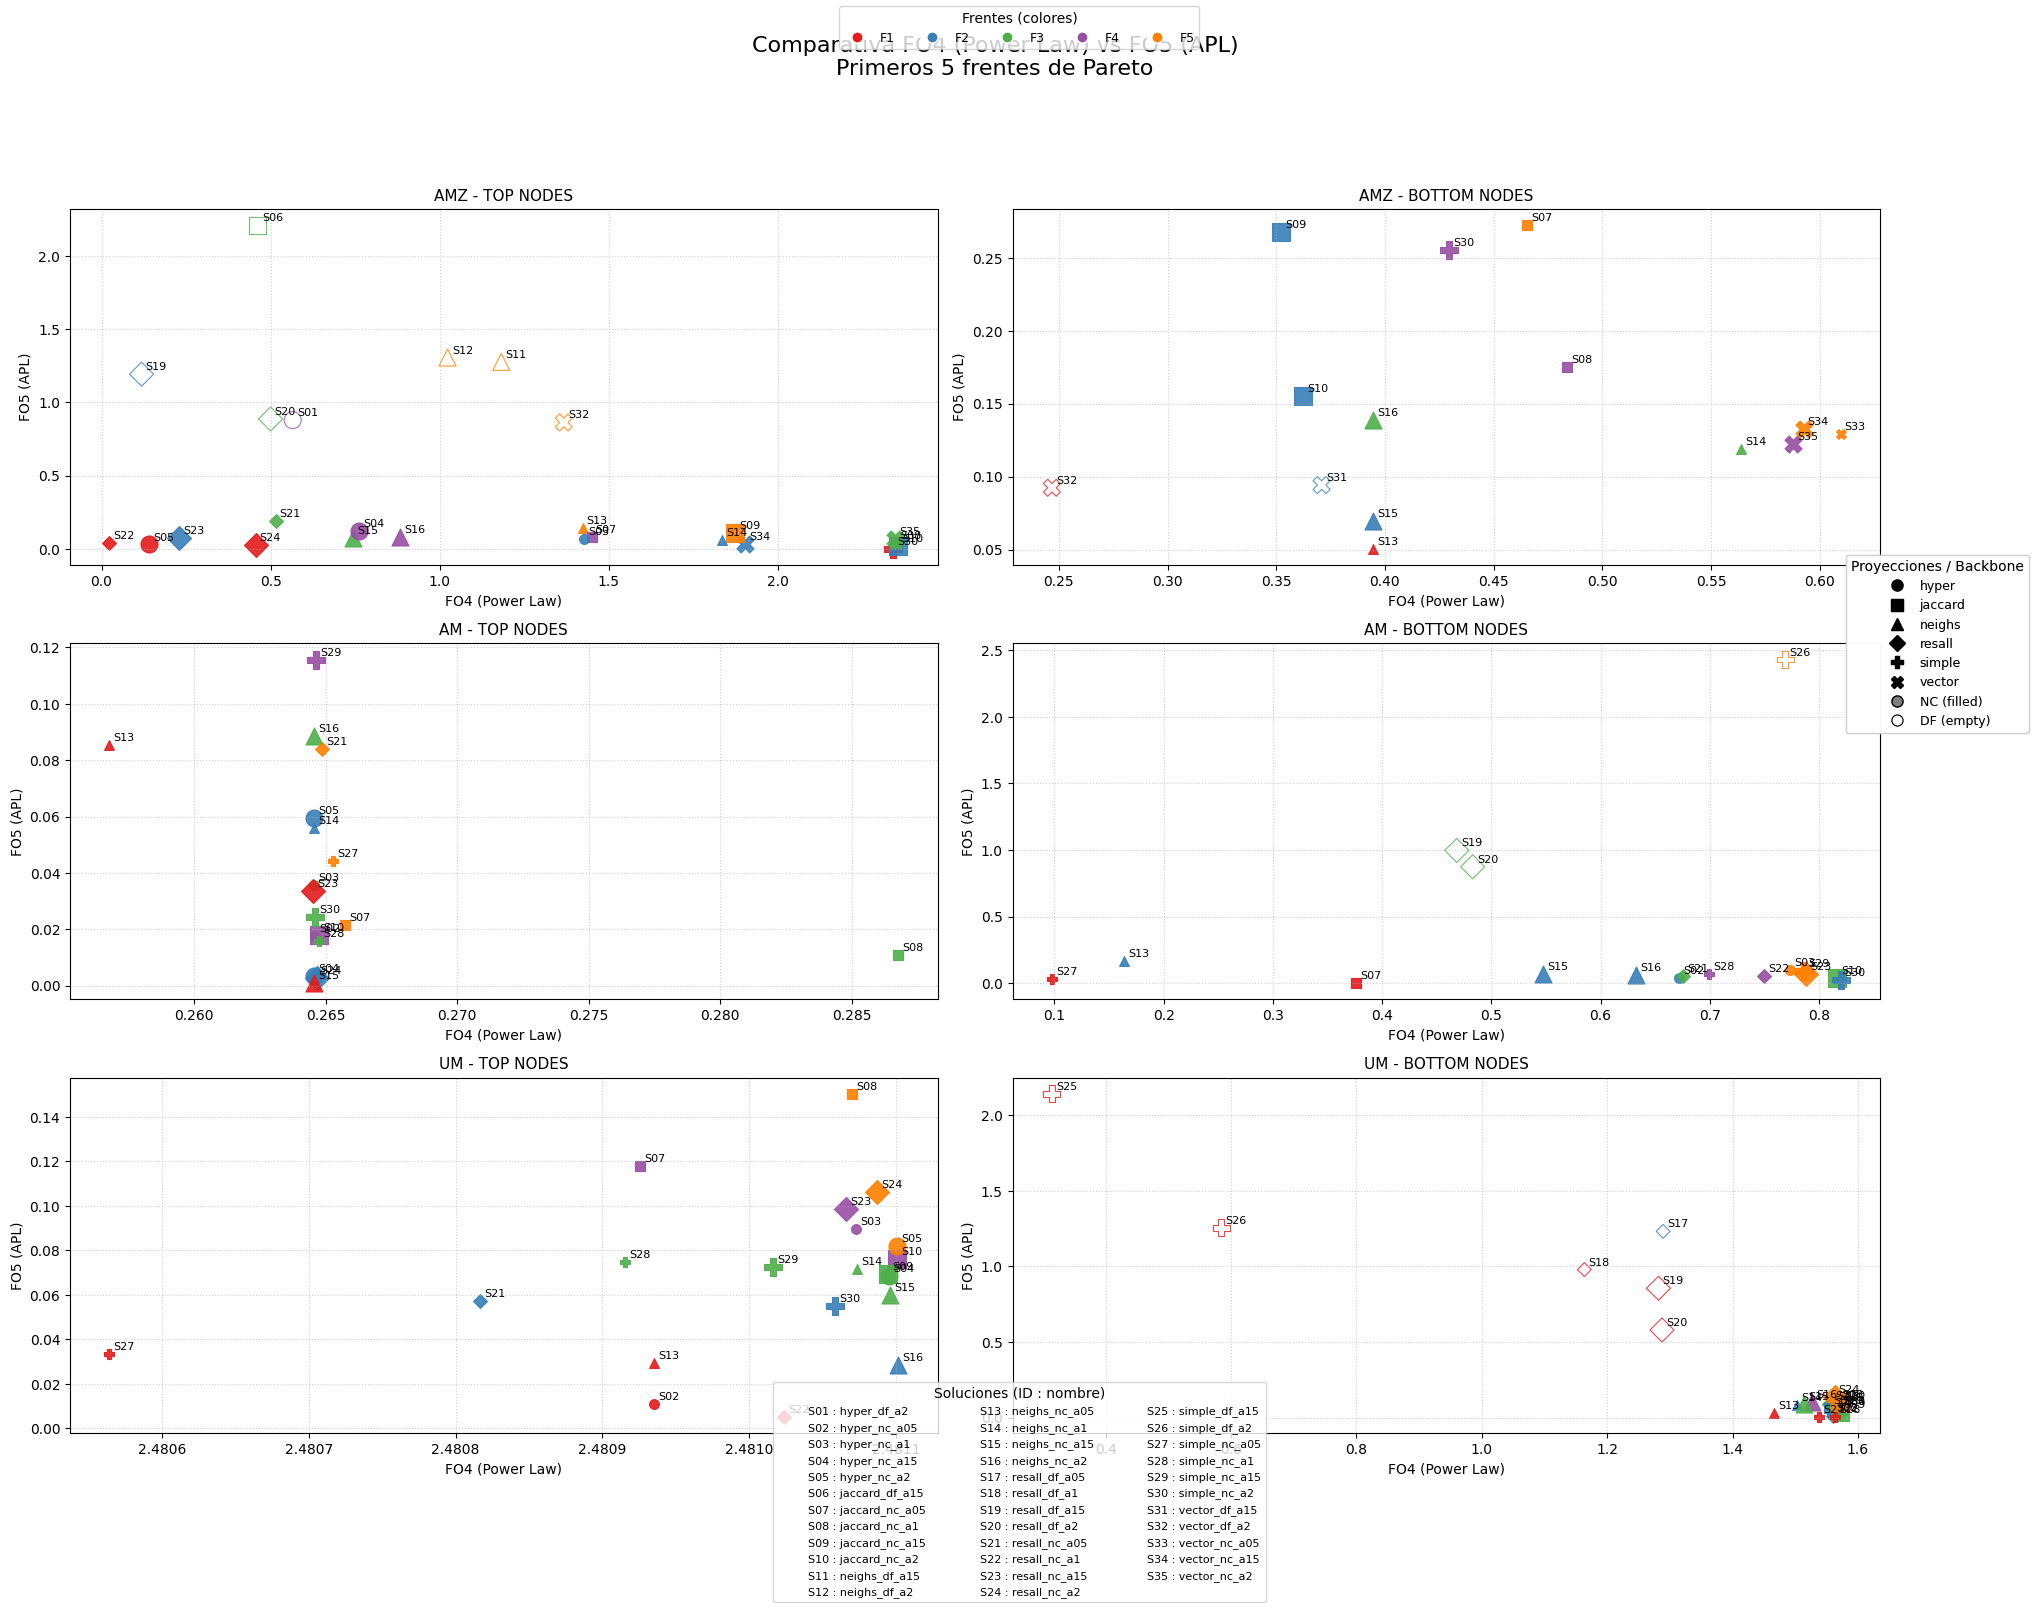

In [10]:
import os
import pickle
import igraph as ig
import numpy as np
import pandas as pd
import statistics
import matplotlib.cm as cm # <--- ESTO ARREGLA NameError: name 'cm' is not defined
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# --------------------------------------------------------
# CONFIGURACIÓN GENERAL
# --------------------------------------------------------
DATASETS = ["amz", "am", "um"]
NODETYPES = [0, 1]  # 0 = top, 1 = bottom
METRIC_PAIR = (3, 4)  # FO4 vs FO5
FO_NAMES = ['FO1 (Nodos)', 'FO2 (Densidad)', 'FO3 (CC)',
            'FO4 (Power Law)', 'FO5 (APL)', 'FO6 (Grado Promedio)']

# --------------------------------------------------------
# FUNCIONES AUXILIARES (idénticas a las tuyas)
# --------------------------------------------------------
def evaluate_solution(bip, proj, typen, metric_pair):
    all_f_values = [
        abs(bip["x1"] - proj["x4"]) if typen == 0 else abs(bip["x2"] - proj["x4"]),
        abs(((2 * proj["x5"]) / (proj["x4"] * (proj["x4"] - 1))) - bip["x15"]),
        abs(bip["x8"] - proj["x7"]),
        abs(bip["x11"] - proj["x12"]),
        abs(bip["x9"] - proj["x10"]),
        abs(proj["x13"] - bip["x16"])
    ]
    f = np.array([
        all_f_values[metric_pair[0]],
        all_f_values[metric_pair[1]]
    ])
    g = np.array([
        (bip["x1"] / 2) - proj["x4"] if typen == 0 else (bip["x2"] / 2) - proj["x4"],
        (bip["x1"] - 1) - proj["x5"] if typen == 0 else (bip["x2"] - 1) - proj["x5"]
    ])
    return dict(metrics={**bip, **proj}, f=f, g=g, graph=proj)

def is_feasible(sol):
    return np.all(sol["g"] <= 0)

def pareto_rank_all(solutions):
    remaining = solutions.copy()
    fronts = []
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    return fronts

# --------------------------------------------------------
# MÉTRICAS BIPARTITAS (tus valores estáticos)
# --------------------------------------------------------
BIP_METRICS = {
    "amz": {
        0: {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.2629, 'x9': 2.7071, 'x11': 3.8553},
        1: {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.2629, 'x9': 2.9545, 'x11': 2.1547}
    },
    "am": {
        0: {'x1': 511463, 'x2': 127823, 'x3': 511463, 'x8': 0.3253, 'x9': 3.6699, 'x11': 1.8623},
        1: {'x1': 511463, 'x2': 127823, 'x3': 511463, 'x8': 0.3253, 'x9': 3.2322, 'x11': 5.0662}
    },
    "um": {
        0: {'x1': 896302, 'x2': 303617, 'x3': 1199919, 'x8': 0.2571, 'x9': 3.6599, 'x11': 4.4055},
        1: {'x1': 896302, 'x2': 303617, 'x3': 1199919, 'x8': 0.2571, 'x9': 3.1522, 'x11': 4.2186}
    }
}

# --------------------------------------------------------
# UTIL: extraer proyección/backbone/alpha desde base_name robustamente
# base_name viene de: fname.replace("_metrics.pkl","")
# esperamos nombres tipo:
#   amz_top_hyper_NC_a05_metrics.pkl  -> base_name: amz_top_hyper_NC_a05
#   o bien: hyper_NC_a05_metrics.pkl  -> base_name: hyper_NC_a05
# Tomamos los últimos 3 campos como projection, backbone, alpha
# --------------------------------------------------------
def parse_solution_name(base_name):
    parts = base_name.split('_')
    if len(parts) >= 3:
        proj = parts[-3].lower()
        bb = parts[-2].upper()   # 'NC' o 'DF' (forzamos mayúsculas)
        alpha = parts[-1].lower()  # 'a05' ...
    else:
        # fallback defensivo
        proj = parts[0].lower()
        bb = parts[1].upper() if len(parts) > 1 else 'NC'
        alpha = parts[2].lower() if len(parts) > 2 else 'a05'
    # normalizar nombres comunes
    proj = proj.replace('hyperbolic', 'hyper')  # por si acaso
    return proj, bb, alpha

# --------------------------------------------------------
# get_solutions: carga métricas proyectadas y construye plot_DF
# --------------------------------------------------------
def get_solutions(dataset, nodetype, metric_pair):
    print(f"\n>>> Procesando {dataset.upper()} - {'TOP' if nodetype==0 else 'BOTTOM'} NODES")

    # Rutas a archivos (ajusta si tus paths son distintas)
    if dataset == "um":
        FILENAME = "um/user-movie.graphml"
    elif dataset == "am":
        FILENAME = "am/actor-movie.graphml"
    elif dataset == "amz":
        FILENAME = "binet-AMZ-Rw.graphml"

    # Leer grafo para calcular x15 y x16
    gb = ig.Graph.Read_GraphML(FILENAME)

    # bip metrics base + x15, x16 calculadas
    bip_metrics = BIP_METRICS[dataset][nodetype].copy()
    bip_metrics['x15'] = gb.density()
    bip_metrics['x16'] = statistics.mean(gb.degree(gb.vs.select(type=nodetype)))

    proj_dir = dataset + ("/top" if nodetype == 0 else "/bot")
    metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
    if not os.path.isdir(metrics_cache_dir):
        print(f"Warning: no existe el directorio {metrics_cache_dir}. Se omite.")
        return pd.DataFrame(), []

    metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]
    if not metrics_files:
        print(f"Warning: no hay archivos *_metrics.pkl en {metrics_cache_dir}.")
        return pd.DataFrame(), []

    records = []
    solutions = []

    for fname in metrics_files:
        base_name = fname.replace("_metrics.pkl", "")
        with open(os.path.join(metrics_cache_dir, fname), 'rb') as fh:
            proj_metrics = pickle.load(fh)

        sol = evaluate_solution(bip_metrics, proj_metrics, nodetype, metric_pair)
        # parsear solución sin prefijo dataset/nodetype:
        proj_name, bb_name, alpha_val = parse_solution_name(base_name)
        solution_key = f"{proj_name}_{bb_name.lower()}_{alpha_val}"  # ej. hyper_nc_a05

        sol["filename"] = base_name  # archivo original (puede contener dataset prefijo)
        sol["solution_key"] = solution_key  # el identificador que queremos usar (sin dataset)
        if is_feasible(sol):
            solutions.append(sol)
            f1, f2 = sol["f"].tolist()
            records.append({
                "Solucion": solution_key,
                "Proyeccion": proj_name,
                "Backbone": bb_name,
                "Alpha": alpha_val,
                "f1": f1,
                "f2": f2,
                "OriginalFile": base_name
            })

    if not solutions:
        return pd.DataFrame(), []

    all_fronts = pareto_rank_all(solutions)

    # Solo conservamos las soluciones que están en los primeros 5 frentes
    top5_names = [s["solution_key"] for rank, front in enumerate(all_fronts, start=1) if rank <= 5 for s in front]
    plot_DF = pd.DataFrame(records)
    plot_DF = plot_DF[plot_DF["Solucion"].isin(top5_names)].reset_index(drop=True)

    # Agregar columna "Frente" usando el mapping por filename (buscamos filename->rank)
    frente_map = {}
    for rank, front in enumerate(all_fronts, start=1):
        for s in front:
            # s["solution_key"] es la clave que usamos
            frente_map[s["solution_key"]] = rank
    plot_DF["Frente"] = plot_DF["Solucion"].map(frente_map).fillna(999).astype(int)

    # Añadir metadatos de dataset y tipo para filtrar luego
    plot_DF["Dataset"] = dataset.upper()
    plot_DF["Tipo"] = "TOP" if nodetype == 0 else "BOTTOM"

    return plot_DF, all_fronts

# --------------------------------------------------------
# RECOLECTAR TODOS LOS DATOS PARA LAS 6 SUBGRÁFICAS
# --------------------------------------------------------
all_plots = []
all_fronts_global = {}  # opcional: almacenar frentes por dataset/nodetype

for dataset in DATASETS:
    for nodetype in NODETYPES:
        df, fronts = get_solutions(dataset, nodetype, METRIC_PAIR)
        if not df.empty:
            all_plots.append(df)
        all_fronts_global[(dataset, nodetype)] = fronts

if not all_plots:
    raise SystemExit("No se encontraron soluciones factibles en ninguno de los datasets/directorios.")

plot_DF = pd.concat(all_plots, ignore_index=True)

# --------------------------------------------------------
# CONFIGURACIÓN DE MARCADORES, RELLENO Y TAMAÑOS (según tus reglas)
# --------------------------------------------------------
# Markers por proyección (asegura cubrir tus 6 nombres)
unique_projections = sorted(plot_DF['Proyeccion'].unique())
marker_list = ['o', 's', '^', 'D', 'P', 'X', 'v', 'p', '*']
PROJ_MARKERS = dict(zip(unique_projections, marker_list[:len(unique_projections)]))

# Backbone: NC -> lleno (True), DF -> no lleno (False)
BB_FILLED_STATUS = {'NC': True, 'DF': False}
# Si hay otros valores, asumimos DF por defecto
plot_DF['is_filled'] = plot_DF['Backbone'].map(lambda x: BB_FILLED_STATUS.get(x, False))

# Alpha -> tamaños
def alpha_size(alpha_str):
    a = alpha_str.lower()
    if a in ('a05', 'a1'):      # pequeño
        return 50
    if a in ('a15', 'a2'):      # grande
        return 150
    # por defecto tamaño medio
    return 100

plot_DF['size'] = plot_DF['Alpha'].map(alpha_size)

# --------------------------------------------------------
# Colores por frente: usaremos frentes 1..5 (si faltan algunos, no importa)
# --------------------------------------------------------
max_front = 5
# OPCIÓN 1: Paleta tab10 (muy clara y contrastante, recomendada)
palette = ListedColormap([
    "#E41A1C",  # rojo fuerte
    "#377EB8",  # azul intenso
    "#4DAF4A",  # verde
    "#984EA3",  # violeta
    "#FF7F00"   # naranja
])

# Asigna color a cada frente de Pareto
FRONT_COLORS = {r: palette(r - 1) for r in range(1, max_front + 1)}

# --------------------------------------------------------
# Generar IDs consistentes S01, S02, ... basados en soluciones únicas
# (ordenadas alfabéticamente para consistencia)
# --------------------------------------------------------
unique_sols = sorted(plot_DF['Solucion'].unique())
shared_ids = {sol: f"S{idx+1:02d}" for idx, sol in enumerate(unique_sols)}

# --------------------------------------------------------
# CREAR FIGURA 3x2 (AMZ, AM, UM filas × TOP,BOTTOM columnas)
# --------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(20, 16))
fig.suptitle("Comparativa FO4 (Power Law) vs FO5 (APL)\nPrimeros 5 frentes de Pareto", fontsize=16)

f_name1, f_name2 = FO_NAMES[3], FO_NAMES[4]

for i, dataset in enumerate(DATASETS):
    for j, nodetype in enumerate(NODETYPES):
        ax = axes[i, j]
        sub_df = plot_DF[(plot_DF["Dataset"] == dataset.upper()) &
                         (plot_DF["Tipo"] == ("TOP" if nodetype == 0 else "BOTTOM"))]

        ax.set_title(f"{dataset.upper()} - {'TOP' if nodetype==0 else 'BOTTOM'} NODES", fontsize=11)
        ax.set_xlabel(f_name1)
        ax.set_ylabel(f_name2)
        ax.grid(True, linestyle=":", alpha=0.6)

        # si no hay datos, indicarlo
        if sub_df.empty:
            ax.text(0.5, 0.5, "No hay soluciones\n(ó no hay archivos)", ha='center', va='center', fontsize=10)
            continue

        # Graficar cada punto según reglas
        for _, row in sub_df.iterrows():
            rank = int(row["Frente"])
            if rank < 1 or rank > 5:
                continue  # mostramos solo frentes 1..5

            color = FRONT_COLORS.get(rank, (0.6, 0.6, 0.6))
            marker = PROJ_MARKERS.get(row["Proyeccion"], 'o')
            face = color if row['is_filled'] else 'none'
            edge = color

            ax.scatter(
                row["f1"], row["f2"],
                s=row["size"],
                marker=marker,
                facecolors=face,
                edgecolors=edge,
                linewidth=0.8,
                alpha=0.9 if row['is_filled'] else 0.8
            )

            # Anotar con ID compartida
            ax.annotate(shared_ids[row["Solucion"]],
                        (row["f1"], row["f2"]),
                        fontsize=8, textcoords="offset points", xytext=(3, 3))

# --------------------------------------------------------
# LEYENDA GLOBAL: Frentes (colores)
# --------------------------------------------------------
front_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=FRONT_COLORS[f], label=f'F{f}',
               markersize=8)
    for f in sorted(FRONT_COLORS.keys())
]
fig.legend(handles=front_handles, title="Frentes (colores)", loc='upper center', ncol=len(front_handles), fontsize=9)

# --------------------------------------------------------
# LEYENDA GLOBAL: Proyecciones (marcadores) y Backbone (filled vs empty)
# Creamos handles por proyección y por tipo backbone
# --------------------------------------------------------
proj_handles = []
for proj, m in PROJ_MARKERS.items():
    h = plt.Line2D([], [], marker=m, color='black', linestyle='',
                   markerfacecolor='black', markersize=8, label=proj)
    proj_handles.append(h)

bb_filled = plt.Line2D([], [], marker='o', color='black', linestyle='', markerfacecolor='gray', markersize=8, label='NC (filled)')
bb_empty = plt.Line2D([], [], marker='o', color='black', linestyle='', markerfacecolor='none', markeredgewidth=0.8, markersize=8, label='DF (empty)')

# Colocamos la leyenda de proyecciones y backbones a la derecha
leg1 = fig.legend(handles=proj_handles[:6] + [bb_filled, bb_empty], title="Proyecciones / Backbone",
                  loc='center right', bbox_to_anchor=(1.02, 0.6), fontsize=9)

# --------------------------------------------------------
# LEYENDA GLOBAL: Soluciones (Sxx : nombre)
# --------------------------------------------------------
solution_labels = [f"{shared_ids[sol]} : {sol}" for sol in unique_sols]
# Para no saturar, colocamos en varias columnas
ncols = 3
# Crear un conjunto de Line2D proxies con labels
solution_proxies = [plt.Line2D([], [], linestyle='none') for _ in solution_labels]
leg2 = fig.legend(solution_proxies, solution_labels, title="Soluciones (ID : nombre)",
                  loc='lower center', ncol=ncols, fontsize=8)

# Añadir la leyenda de proyecciones/backbones al axes para que no se remueva
fig.gca().add_artist(leg1)

plt.tight_layout(rect=[0, 0.07, 0.95, 0.93])
plt.show()




>>> Procesando AMZ - TOP NODES

>>> Procesando AMZ - BOTTOM NODES

>>> Procesando AM - TOP NODES


/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_48123/1469255294.py:121: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)
/var/folders/g4/vgr09c9n7pd31lk61zpr3_440000gn/T/ipykernel_48123/1469255294.py:121: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  gb = ig.Graph.Read_GraphML(FILENAME)



>>> Procesando AM - BOTTOM NODES

>>> Procesando UM - TOP NODES

>>> Procesando UM - BOTTOM NODES


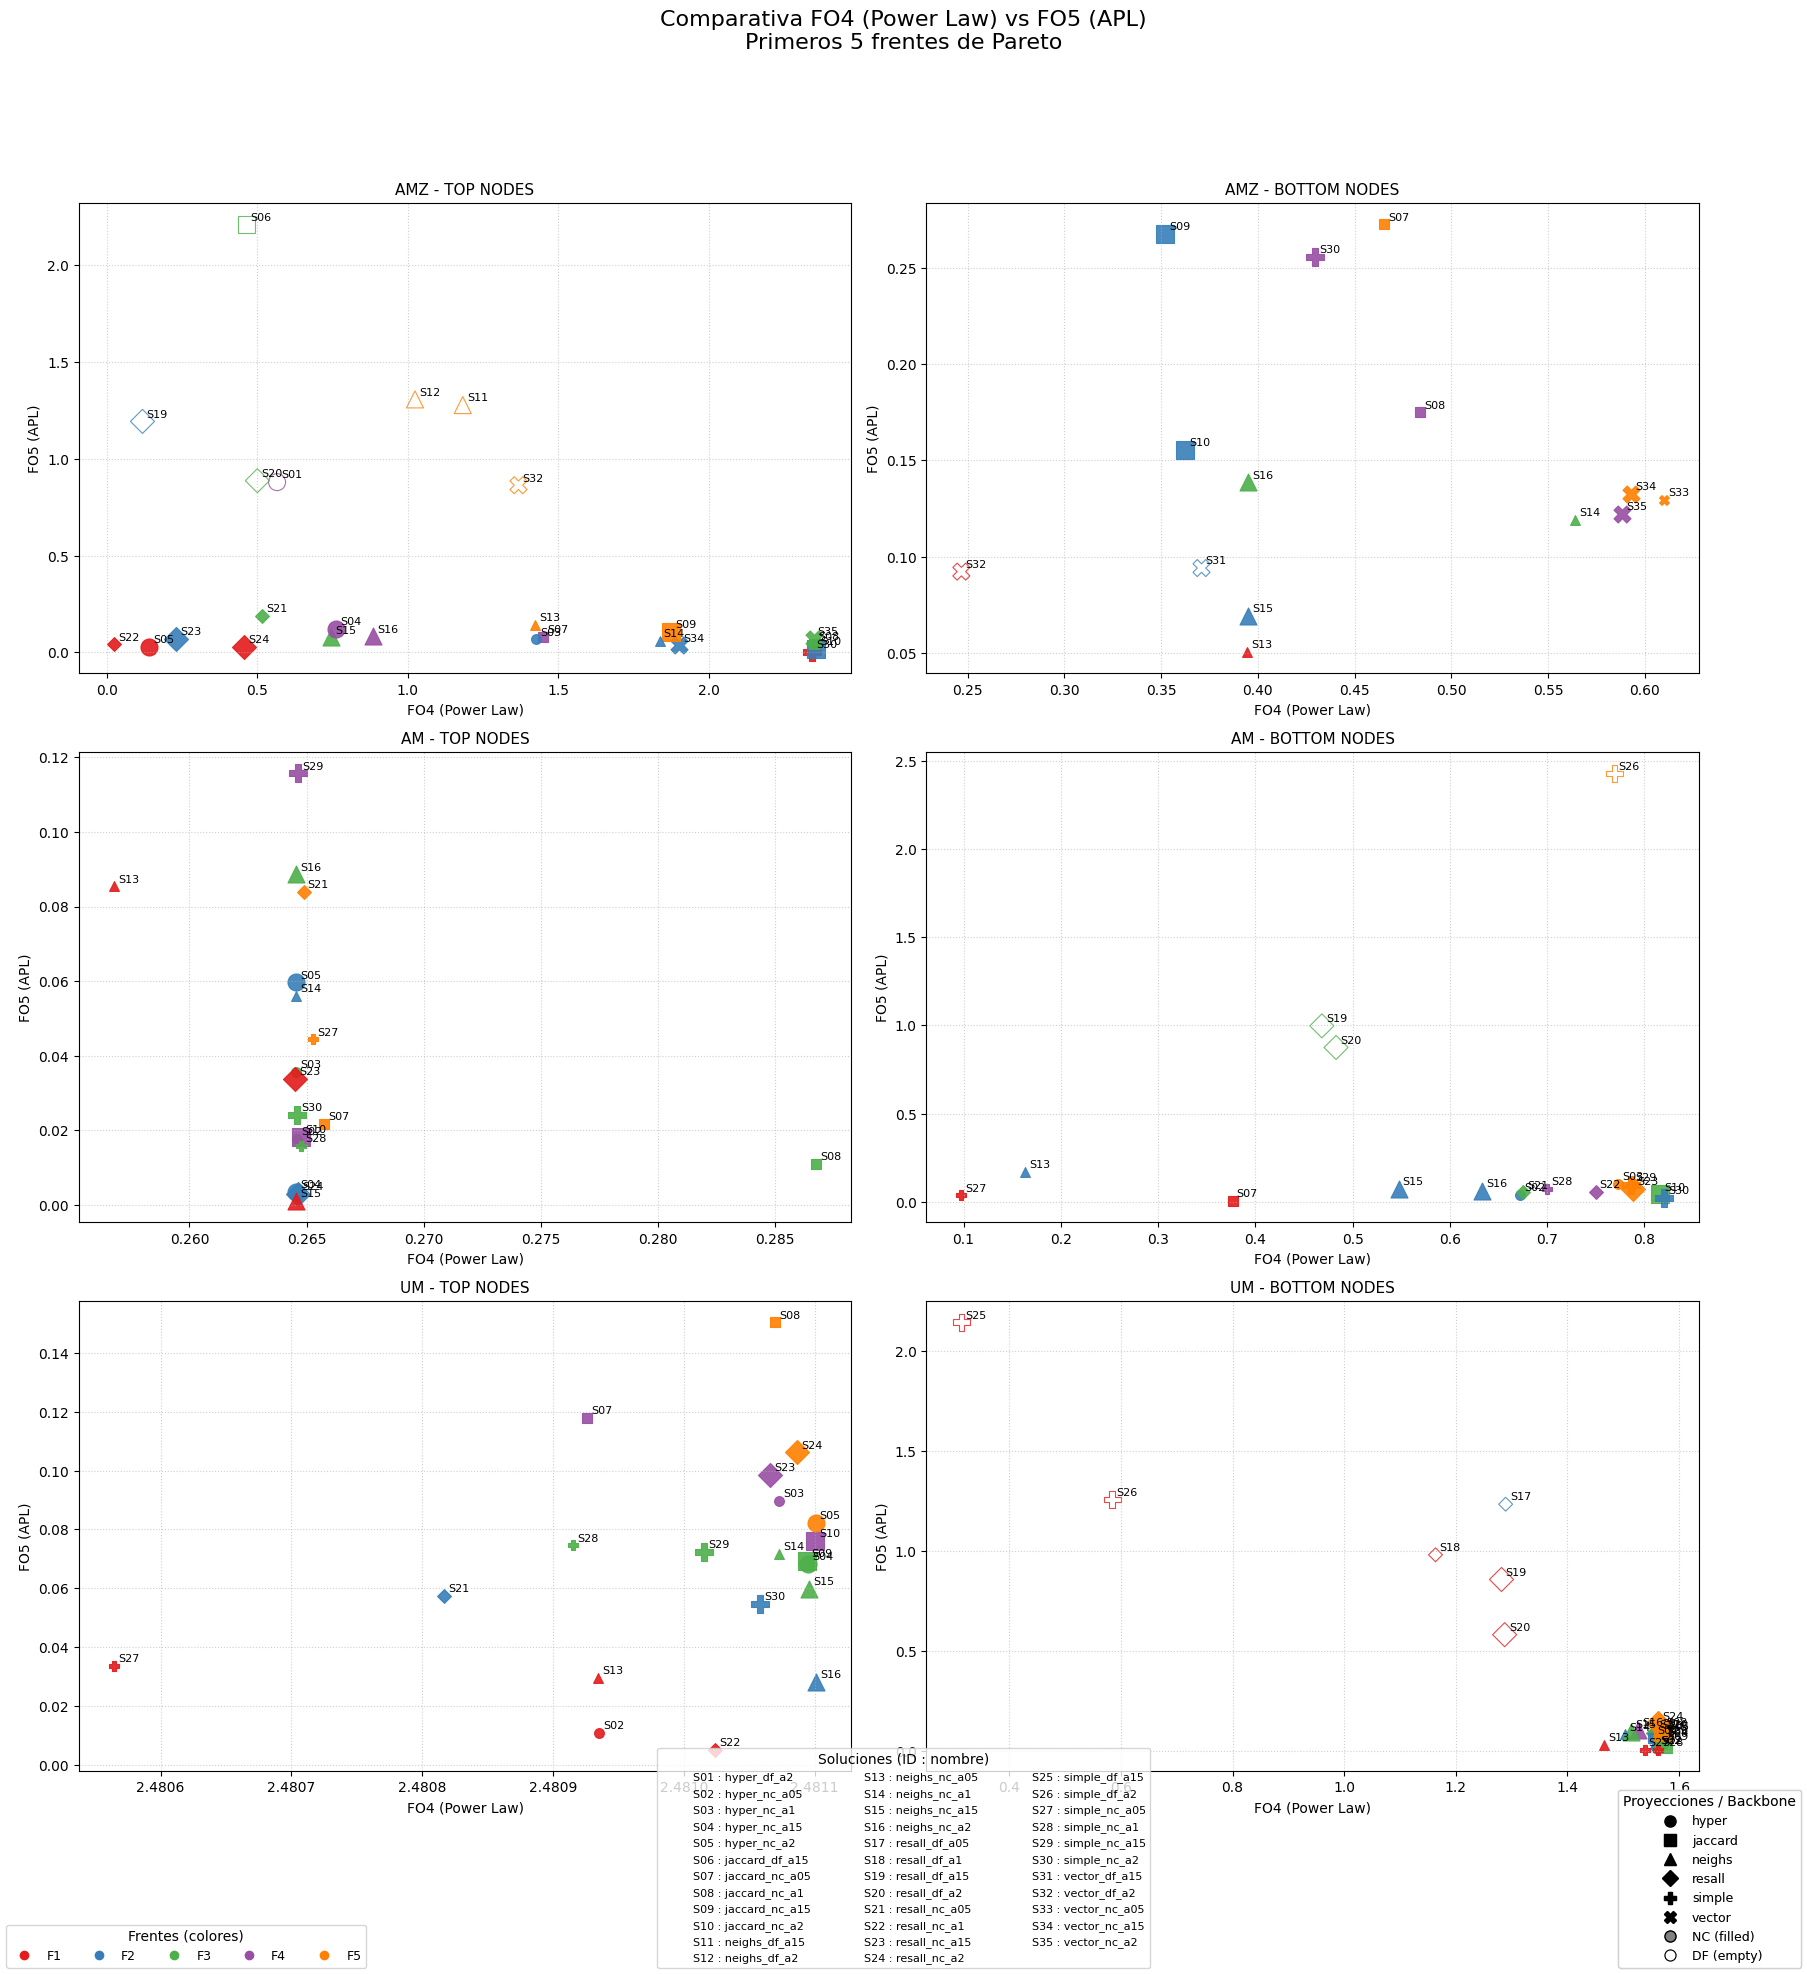

In [13]:
import os
import pickle
import igraph as ig
import numpy as np
import pandas as pd
import statistics
import matplotlib.cm as cm # <--- ESTO ARREGLA NameError: name 'cm' is not defined
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# --------------------------------------------------------
# CONFIGURACIÓN GENERAL
# --------------------------------------------------------
DATASETS = ["amz", "am", "um"]
NODETYPES = [0, 1]  # 0 = top, 1 = bottom
METRIC_PAIR = (3, 4)  # FO4 vs FO5
FO_NAMES = ['FO1 (Nodos)', 'FO2 (Densidad)', 'FO3 (CC)',
            'FO4 (Power Law)', 'FO5 (APL)', 'FO6 (Grado Promedio)']

# --------------------------------------------------------
# FUNCIONES AUXILIARES (idénticas a las tuyas)
# --------------------------------------------------------
def evaluate_solution(bip, proj, typen, metric_pair):
    all_f_values = [
        abs(bip["x1"] - proj["x4"]) if typen == 0 else abs(bip["x2"] - proj["x4"]),
        abs(((2 * proj["x5"]) / (proj["x4"] * (proj["x4"] - 1))) - bip["x15"]),
        abs(bip["x8"] - proj["x7"]),
        abs(bip["x11"] - proj["x12"]),
        abs(bip["x9"] - proj["x10"]),
        abs(proj["x13"] - bip["x16"])
    ]
    f = np.array([
        all_f_values[metric_pair[0]],
        all_f_values[metric_pair[1]]
    ])
    g = np.array([
        (bip["x1"] / 2) - proj["x4"] if typen == 0 else (bip["x2"] / 2) - proj["x4"],
        (bip["x1"] - 1) - proj["x5"] if typen == 0 else (bip["x2"] - 1) - proj["x5"]
    ])
    return dict(metrics={**bip, **proj}, f=f, g=g, graph=proj)

def is_feasible(sol):
    return np.all(sol["g"] <= 0)

def pareto_rank_all(solutions):
    remaining = solutions.copy()
    fronts = []
    while remaining:
        current_front = []
        for i, si in enumerate(remaining):
            dominated = False
            for j, sj in enumerate(remaining):
                if i == j:
                    continue
                if np.all(sj["f"] <= si["f"]) and np.any(sj["f"] < si["f"]):
                    dominated = True
                    break
            if not dominated:
                current_front.append(si)
        fronts.append(current_front)
        remaining = [s for s in remaining if all(s is not r for r in current_front)]
    return fronts

# --------------------------------------------------------
# MÉTRICAS BIPARTITAS (tus valores estáticos)
# --------------------------------------------------------
BIP_METRICS = {
    "amz": {
        0: {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.2629, 'x9': 2.7071, 'x11': 3.8553},
        1: {'x1': 9561, 'x2': 7518, 'x3': 32769, 'x8': 0.2629, 'x9': 2.9545, 'x11': 2.1547}
    },
    "am": {
        0: {'x1': 511463, 'x2': 127823, 'x3': 511463, 'x8': 0.3253, 'x9': 3.6699, 'x11': 1.8623},
        1: {'x1': 511463, 'x2': 127823, 'x3': 511463, 'x8': 0.3253, 'x9': 3.2322, 'x11': 5.0662}
    },
    "um": {
        0: {'x1': 896302, 'x2': 303617, 'x3': 1199919, 'x8': 0.2571, 'x9': 3.6599, 'x11': 4.4055},
        1: {'x1': 896302, 'x2': 303617, 'x3': 1199919, 'x8': 0.2571, 'x9': 3.1522, 'x11': 4.2186}
    }
}

# --------------------------------------------------------
# UTIL: extraer proyección/backbone/alpha desde base_name robustamente
# base_name viene de: fname.replace("_metrics.pkl","")
# esperamos nombres tipo:
#   amz_top_hyper_NC_a05_metrics.pkl  -> base_name: amz_top_hyper_NC_a05
#   o bien: hyper_NC_a05_metrics.pkl  -> base_name: hyper_NC_a05
# Tomamos los últimos 3 campos como projection, backbone, alpha
# --------------------------------------------------------
def parse_solution_name(base_name):
    parts = base_name.split('_')
    if len(parts) >= 3:
        proj = parts[-3].lower()
        bb = parts[-2].upper()   # 'NC' o 'DF' (forzamos mayúsculas)
        alpha = parts[-1].lower()  # 'a05' ...
    else:
        # fallback defensivo
        proj = parts[0].lower()
        bb = parts[1].upper() if len(parts) > 1 else 'NC'
        alpha = parts[2].lower() if len(parts) > 2 else 'a05'
    # normalizar nombres comunes
    proj = proj.replace('hyperbolic', 'hyper')  # por si acaso
    return proj, bb, alpha

# --------------------------------------------------------
# get_solutions: carga métricas proyectadas y construye plot_DF
# --------------------------------------------------------
def get_solutions(dataset, nodetype, metric_pair):
    print(f"\n>>> Procesando {dataset.upper()} - {'TOP' if nodetype==0 else 'BOTTOM'} NODES")

    # Rutas a archivos (ajusta si tus paths son distintas)
    if dataset == "um":
        FILENAME = "um/user-movie.graphml"
    elif dataset == "am":
        FILENAME = "am/actor-movie.graphml"
    elif dataset == "amz":
        FILENAME = "binet-AMZ-Rw.graphml"

    # Leer grafo para calcular x15 y x16
    gb = ig.Graph.Read_GraphML(FILENAME)

    # bip metrics base + x15, x16 calculadas
    bip_metrics = BIP_METRICS[dataset][nodetype].copy()
    bip_metrics['x15'] = gb.density()
    bip_metrics['x16'] = statistics.mean(gb.degree(gb.vs.select(type=nodetype)))

    proj_dir = dataset + ("/top" if nodetype == 0 else "/bot")
    metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
    if not os.path.isdir(metrics_cache_dir):
        print(f"Warning: no existe el directorio {metrics_cache_dir}. Se omite.")
        return pd.DataFrame(), []

    metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]
    if not metrics_files:
        print(f"Warning: no hay archivos *_metrics.pkl en {metrics_cache_dir}.")
        return pd.DataFrame(), []

    records = []
    solutions = []

    for fname in metrics_files:
        base_name = fname.replace("_metrics.pkl", "")
        with open(os.path.join(metrics_cache_dir, fname), 'rb') as fh:
            proj_metrics = pickle.load(fh)

        sol = evaluate_solution(bip_metrics, proj_metrics, nodetype, metric_pair)
        # parsear solución sin prefijo dataset/nodetype:
        proj_name, bb_name, alpha_val = parse_solution_name(base_name)
        solution_key = f"{proj_name}_{bb_name.lower()}_{alpha_val}"  # ej. hyper_nc_a05

        sol["filename"] = base_name  # archivo original (puede contener dataset prefijo)
        sol["solution_key"] = solution_key  # el identificador que queremos usar (sin dataset)
        if is_feasible(sol):
            solutions.append(sol)
            f1, f2 = sol["f"].tolist()
            records.append({
                "Solucion": solution_key,
                "Proyeccion": proj_name,
                "Backbone": bb_name,
                "Alpha": alpha_val,
                "f1": f1,
                "f2": f2,
                "OriginalFile": base_name
            })

    if not solutions:
        return pd.DataFrame(), []

    all_fronts = pareto_rank_all(solutions)

    # Solo conservamos las soluciones que están en los primeros 5 frentes
    top5_names = [s["solution_key"] for rank, front in enumerate(all_fronts, start=1) if rank <= 5 for s in front]
    plot_DF = pd.DataFrame(records)
    plot_DF = plot_DF[plot_DF["Solucion"].isin(top5_names)].reset_index(drop=True)

    # Agregar columna "Frente" usando el mapping por filename (buscamos filename->rank)
    frente_map = {}
    for rank, front in enumerate(all_fronts, start=1):
        for s in front:
            # s["solution_key"] es la clave que usamos
            frente_map[s["solution_key"]] = rank
    plot_DF["Frente"] = plot_DF["Solucion"].map(frente_map).fillna(999).astype(int)

    # Añadir metadatos de dataset y tipo para filtrar luego
    plot_DF["Dataset"] = dataset.upper()
    plot_DF["Tipo"] = "TOP" if nodetype == 0 else "BOTTOM"

    return plot_DF, all_fronts

# --------------------------------------------------------
# RECOLECTAR TODOS LOS DATOS PARA LAS 6 SUBGRÁFICAS
# --------------------------------------------------------
all_plots = []
all_fronts_global = {}  # opcional: almacenar frentes por dataset/nodetype

for dataset in DATASETS:
    for nodetype in NODETYPES:
        df, fronts = get_solutions(dataset, nodetype, METRIC_PAIR)
        if not df.empty:
            all_plots.append(df)
        all_fronts_global[(dataset, nodetype)] = fronts

if not all_plots:
    raise SystemExit("No se encontraron soluciones factibles en ninguno de los datasets/directorios.")

plot_DF = pd.concat(all_plots, ignore_index=True)

# --------------------------------------------------------
# CONFIGURACIÓN DE MARCADORES, RELLENO Y TAMAÑOS (según tus reglas)
# --------------------------------------------------------
# Markers por proyección (asegura cubrir tus 6 nombres)
unique_projections = sorted(plot_DF['Proyeccion'].unique())
marker_list = ['o', 's', '^', 'D', 'P', 'X', 'v', 'p', '*']
PROJ_MARKERS = dict(zip(unique_projections, marker_list[:len(unique_projections)]))

# Backbone: NC -> lleno (True), DF -> no lleno (False)
BB_FILLED_STATUS = {'NC': True, 'DF': False}
# Si hay otros valores, asumimos DF por defecto
plot_DF['is_filled'] = plot_DF['Backbone'].map(lambda x: BB_FILLED_STATUS.get(x, False))

# Alpha -> tamaños
def alpha_size(alpha_str):
    a = alpha_str.lower()
    if a in ('a05', 'a1'):      # pequeño
        return 50
    if a in ('a15', 'a2'):      # grande
        return 150
    # por defecto tamaño medio
    return 100

plot_DF['size'] = plot_DF['Alpha'].map(alpha_size)

# --------------------------------------------------------
# Colores por frente: usaremos frentes 1..5 (si faltan algunos, no importa)
# --------------------------------------------------------
max_front = 5
# OPCIÓN 1: Paleta tab10 (muy clara y contrastante, recomendada)
palette = ListedColormap([
    "#E41A1C",  # rojo fuerte
    "#377EB8",  # azul intenso
    "#4DAF4A",  # verde
    "#984EA3",  # violeta
    "#FF7F00"   # naranja
])

# Asigna color a cada frente de Pareto
FRONT_COLORS = {r: palette(r - 1) for r in range(1, max_front + 1)}

# --------------------------------------------------------
# Generar IDs consistentes S01, S02, ... basados en soluciones únicas
# (ordenadas alfabéticamente para consistencia)
# --------------------------------------------------------
unique_sols = sorted(plot_DF['Solucion'].unique())
shared_ids = {sol: f"S{idx+1:02d}" for idx, sol in enumerate(unique_sols)}

# --------------------------------------------------------
# CREAR FIGURA 3x2 (AMZ, AM, UM filas × TOP,BOTTOM columnas)
# --------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.suptitle("Comparativa FO4 (Power Law) vs FO5 (APL)\nPrimeros 5 frentes de Pareto", fontsize=16)

f_name1, f_name2 = FO_NAMES[3], FO_NAMES[4]

for i, dataset in enumerate(DATASETS):
    for j, nodetype in enumerate(NODETYPES):
        ax = axes[i, j]
        sub_df = plot_DF[(plot_DF["Dataset"] == dataset.upper()) &
                         (plot_DF["Tipo"] == ("TOP" if nodetype == 0 else "BOTTOM"))]

        ax.set_title(f"{dataset.upper()} - {'TOP' if nodetype==0 else 'BOTTOM'} NODES", fontsize=11)
        ax.set_xlabel(f_name1)
        ax.set_ylabel(f_name2)
        ax.grid(True, linestyle=":", alpha=0.6)

        # si no hay datos, indicarlo
        if sub_df.empty:
            ax.text(0.5, 0.5, "No hay soluciones\n(ó no hay archivos)", ha='center', va='center', fontsize=10)
            continue

        # Graficar cada punto según reglas
        for _, row in sub_df.iterrows():
            rank = int(row["Frente"])
            if rank < 1 or rank > 5:
                continue  # mostramos solo frentes 1..5

            color = FRONT_COLORS.get(rank, (0.6, 0.6, 0.6))
            marker = PROJ_MARKERS.get(row["Proyeccion"], 'o')
            face = color if row['is_filled'] else 'none'
            edge = color

            ax.scatter(
                row["f1"], row["f2"],
                s=row["size"],
                marker=marker,
                facecolors=face,
                edgecolors=edge,
                linewidth=0.8,
                alpha=0.9 if row['is_filled'] else 0.8
            )

            # Anotar con ID compartida
            ax.annotate(shared_ids[row["Solucion"]],
                        (row["f1"], row["f2"]),
                        fontsize=8, textcoords="offset points", xytext=(3, 3))

# --------------------------------------------------------
# LEYENDA GLOBAL: Frentes (colores)
# --------------------------------------------------------
front_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=FRONT_COLORS[f], label=f'F{f}',
               markersize=8)
    for f in sorted(FRONT_COLORS.keys())
]
fig.legend(handles=front_handles, title="Frentes (colores)", loc='lower left', ncol=len(front_handles), fontsize=9)

# --------------------------------------------------------
# LEYENDA GLOBAL: Proyecciones (marcadores) y Backbone (filled vs empty)
# Creamos handles por proyección y por tipo backbone
# --------------------------------------------------------
proj_handles = []
for proj, m in PROJ_MARKERS.items():
    h = plt.Line2D([], [], marker=m, color='black', linestyle='',
                   markerfacecolor='black', markersize=8, label=proj)
    proj_handles.append(h)

bb_filled = plt.Line2D([], [], marker='o', color='black', linestyle='', markerfacecolor='gray', markersize=8, label='NC (filled)')
bb_empty = plt.Line2D([], [], marker='o', color='black', linestyle='', markerfacecolor='none', markeredgewidth=0.8, markersize=8, label='DF (empty)')

# Colocamos la leyenda de proyecciones y backbones a la derecha
leg1 = fig.legend(handles=proj_handles[:6] + [bb_filled, bb_empty], title="Proyecciones / Backbone",
                  loc='lower right', fontsize=9)

# --------------------------------------------------------
# LEYENDA GLOBAL: Soluciones (Sxx : nombre)
# --------------------------------------------------------
solution_labels = [f"{shared_ids[sol]} : {sol}" for sol in unique_sols]
# Para no saturar, colocamos en varias columnas
ncols = 3
# Crear un conjunto de Line2D proxies con labels
solution_proxies = [plt.Line2D([], [], linestyle='none') for _ in solution_labels]
leg2 = fig.legend(solution_proxies, solution_labels, title="Soluciones (ID : nombre)",
                  loc='lower center', ncol=ncols, fontsize=8)

# Añadir la leyenda de proyecciones/backbones al axes para que no se remueva
fig.gca().add_artist(leg1)

plt.tight_layout(rect=[0, 0.07, 0.95, 0.93])
plt.show()

